In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(
                                       legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            axis.text.y=element_text(size=16),

                            axis.text.x=element_text(size=16),
                         axis.title.x=element_text(face="plain"),
                            axis.title.y=element_text(face="plain"))
# title =element_text(size=16, face='bold'))

paper_theme_3 <- theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/pyth

In [4]:
%%R --o data_resp

data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")
data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))


data_resp <- data_resp_loc %>%
     #mutate(Dots_Counted=max(min(5*Dots_Shown, Dots_Counted),0.1*Dots_Shown)) %>%

      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
      #mutate(gazeDist=max(0,gazeDist)) %>%

      mutate(err=Dots_Counted - Dots_Shown) %>%
      mutate(abs_err = abs(err)) %>%
      mutate(within_x = 2/(1 + exp(-0.6 -0.2*belowX)) - 1) %>%
      group_by(trial_id) %>% 
      mutate(belowX = mean(belowX)) %>%
      mutate(within_x = mean(within_x)) %>%
      mutate(nLooks=mean(nLooks)) %>%
      #mutate(within_x=mean(pInGaze**0.2)) %>%

      mutate(within_x_tot = sum(within_x)) %>%
      mutate(nLooks = mean(nLooks)) %>%
      mutate(pathLength = mean(pathLength)) %>%
      mutate(medFix = mean(medFix)) %>%
      mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
      mutate(mean_abs_err = mean(abs_err)) %>%
      mutate(pct_err=err/Dots_Shown) %>%
        mutate(abs_pct_err=abs_err/Dots_Shown) %>%

      top_n(n=1, wt=id)  %>%
      filter(abs_pct_err <= 1.) %>%
      group_by(Subject, pid)%>%
      filter(length(Subject) > 0) 


data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))
data_resp$Time <- as.factor(round(data_resp$Time,2))



In [5]:
data_resp = pandas2ri.ri2py(data_resp)

In [26]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


subj_group = data_resp.groupby(["pid", "Subject"])
#subj_group = data_resp.groupby(["pid", "Subject", "Time"])
#subj_group = data_resp.groupby(["Time"])

dots_shown,dots_counted,pct_area,seen,n_look,times,pid=[],[],[],[],[],[],[]
for i,subj in subj_group:
    times.append([float(i) for i in list(subj["Time"])])
    dots_shown.append(list(subj["Dots_Shown"]))
    dots_counted.append(list(subj["Dots_Counted"]))
    pct_area.append(list(subj["pctArea"] * 0.95))
    seen.append(list(subj["within_x_tot"]))
    n_look.append(list(subj["nLooks"]))
    pid.append(list(subj["Subject"]))

ns = [len(n) for n in seen]
min_n = min(ns)



dots_shown = remove_n(dots_shown, min_n)
pid = remove_n(pid, min_n)
dots_counted = remove_n(dots_counted, min_n)
pct_area = remove_n(pct_area, min_n)
seen = remove_n(seen, min_n)
n_look = remove_n(n_look, min_n)
times = remove_n(times, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
pct_area=np.array(pct_area)
seen=np.array(seen)
n_look = np.array(n_look)
times = np.array(times)
unseen = dots_shown - seen
pid=np.array(pid)



with pm.Model() as mod:
    
    beta_group_mean = pm.Normal("beta_grp_mu", mu=0, sd=5,testval=0)
   # weber_group_mean = pm.Normal("weber_grp_mu", mu=0, sd=5,testval=0)
    weber_group_mean = pm.Normal("weber_grp_mu", mu=-0.1, sd=0.01,testval=0)

    #weber_grp_sd = pm.HalfNormal("weber_grp_sd",sd=5,testval=0.3)
    weber_time_group_mean = pm.Normal("weber_time_grp_mu",mu=0, sd=5,testval=0)
    beta_time_group_mean = pm.Normal("beta_time_grp_mu",mu=0, sd=5,testval=0)
    
    
    beta_group_sd = pm.HalfNormal("beta_grp_sd",sd=5,testval=1)
    weber_group_sd = pm.HalfNormal("weber_grp_sd",sd=5,testval=1)

    weber_time_group_sd = pm.HalfNormal("weber_time_grp_sd", sd=5,testval=1)
    beta_time_group_sd = pm.HalfNormal("beta_time_grp_sd",sd=5,testval=1)
    #beta_grp_mu=0.8
    #beta_grp_sd=10
    #weber_grp_sd=100

  #  time_weber = 0.
   # time_slope = 0.

    #beta = pm.HalfNormal("slope", sd=beta_grp_sd, shape=(len(dots_shown), 1), testval=1)
    #inv_weber = pm.HalfNormal("weber", sd=weber_grp_sd, shape=(len(dots_shown), 1), testval=1)
    #time_weber = pm.HalfNormal("time_weber", sd=10., shape=(len(dots_shown), 1), testval=200)
    #time_slope = pm.HalfNormal("time_slope", sd=2, shape=(len(dots_shown), 1), testval=0.1)
    #weber = 1./inv_weber
    #time_weber = 1./time_weber
    
    beta = pm.Normal("slope", mu=beta_group_mean, 
                             sd=beta_time_group_sd, shape=(len(dots_shown), 1))
    weber = pm.Normal("weber", mu=weber_group_mean,
                          sd=weber_group_sd, shape=(len(dots_shown), 1))
    time_weber = pm.Normal("time_weber",mu=weber_time_group_mean,
                           sd=weber_time_group_sd, shape=(len(dots_shown), 1), testval=0.)
    time_slope = pm.Normal("time_slope",mu=beta_time_group_mean,
                           sd=beta_time_group_sd, shape=(len(dots_shown), 1), testval=0.)
    

    #dev_unseen = pm.HalfNormal("dev_unseen", sd=5, shape=(len(dots_shown), 1))
    #weber = (weber + abs(weber))/2. + 1e-8 #this removes negatives
   # s = tt.exp(beta + time_slope * tt.log(times))
   # w = tt.exp(weber + time_weber*tt.log(times))
    s = tt.exp(beta + time_slope * tt.log(times))
    w = tt.exp(weber + time_weber*tt.log(times))

    
    guess = s  * dots_shown
    guess_sd = w * guess 
    
    #guess_sd += dev_unseen * 
    
    lkhd = pm.Normal("lkhd", mu=guess, sd=guess_sd, observed=dots_counted)
    trace = pm.sample(400, tune=250, cores=2, njobs=2, chains=2)
    

    
    
    

summary = pm.summary(trace)
print(summary)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [time_slope, time_weber, weber, slope, beta_time_grp_sd_log__, weber_time_grp_sd_log__, weber_grp_sd_log__, beta_grp_sd_log__, beta_time_grp_mu, weber_time_grp_mu, weber_grp_mu, beta_grp_mu]
100%|██████████| 650/650 [00:15<00:00, 41.30it/s]
Only 400 samples in chain.
The acceptance probability does not match the target. It is 0.944096389725635, but should be close to 0.8. Try to increase the number of tuning steps.
Only 400 samples in chain.
The acceptance probability does not match the target. It is 0.9860942263317246, but should be close to 0.8. Try to increase the number of tuning step

                       mean        sd  mc_error   hpd_2.5  hpd_97.5  n_eff  \
beta_grp_mu       -0.250903  0.030859  0.000828 -0.307581 -0.184725  800.0   
weber_grp_mu      -0.101607  0.010087  0.000259 -0.122257 -0.082379  800.0   
weber_time_grp_mu -0.022203  0.019088  0.001112 -0.059873  0.012915  242.0   
beta_time_grp_mu   0.052360  0.030175  0.000790 -0.004413  0.111437  800.0   
slope__0_0        -0.283166  0.029202  0.000977 -0.337812 -0.229595  800.0   
slope__1_0        -0.444387  0.025426  0.000957 -0.491269 -0.396629  732.0   
slope__2_0        -0.138835  0.034512  0.001190 -0.208743 -0.071815  800.0   
slope__3_0        -0.169152  0.036956  0.001136 -0.247639 -0.105747  800.0   
slope__4_0        -0.151444  0.030640  0.001013 -0.207863 -0.090192  800.0   
slope__5_0        -0.117120  0.032557  0.001123 -0.185307 -0.058770  800.0   
slope__6_0        -0.244661  0.038975  0.001287 -0.318275 -0.164086  800.0   
slope__7_0        -0.162035  0.031626  0.001033 -0.221648 -0.096

In [27]:
summary_mean = summary["mean"]
summary_sd = summary["sd"]
summary_low = summary["hpd_2.5"]
summary_high = summary["hpd_97.5"]

vals = {}
rownames = list(summary.index)

n_groups = seen.shape[0]
n_per_group = seen.shape[1]

print(summary_mean)
print(summary_sd)


vals = {}
for i in range(len(rownames)):
    rowname = rownames[i]
    rowname = rowname[:rowname.find("__")]
    
    if 'grp' in rowname:
        vals[rowname] = [summary_mean[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_low"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_high"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]

    else:
        if rowname not in vals:
            vals[rowname] = [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group)]
        else:
            vals[rowname] += [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] += [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] += [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] += [summary_high[i] for _ in range(n_per_group)]

   # print((i, (i%n_groups), rownames[i], summary_mean[i]))

vals["pid"] = np.ravel(pid)
vals["Time"] = np.ravel(times)
vals["Dots_Shown"] = np.ravel(dots_shown)
vals["Dots_Counted"] = np.ravel(dots_counted)


sum_vals=pd.DataFrame(vals)
#print(seen.shape)
pandas2ri.py2ri(sum_vals)

beta_grp_mu         -0.250903
weber_grp_mu        -0.101607
weber_time_grp_mu   -0.022203
beta_time_grp_mu     0.052360
slope__0_0          -0.283166
slope__1_0          -0.444387
slope__2_0          -0.138835
slope__3_0          -0.169152
slope__4_0          -0.151444
slope__5_0          -0.117120
slope__6_0          -0.244661
slope__7_0          -0.162035
slope__8_0          -0.117914
slope__9_0          -0.115977
slope__10_0         -0.386425
slope__11_0         -0.632816
slope__12_0         -0.661764
slope__13_0          0.166267
slope__14_0         -0.029012
slope__15_0         -0.433535
slope__16_0         -0.184677
slope__17_0         -0.340782
slope__18_0         -0.195459
slope__19_0         -0.313640
slope__20_0         -0.229128
slope__21_0          0.164119
slope__22_0         -0.234249
slope__23_0         -0.323018
slope__24_0         -0.427876
slope__25_0         -0.517975
                       ...   
time_slope__0_0      0.020072
time_slope__1_0      0.113544
time_slope

Dots_Counted,Dots_Shown,Time,...,weber_time_grp_s_high,weber_time_grp_s_low,weber_time_grp_s_sd
20.000000,18.000000,0.330000,...,0.021342,0.021342,0.021342
60.000000,89.000000,0.330000,...,0.021342,0.021342,0.021342
30.000000,36.000000,0.330000,...,0.021342,0.021342,0.021342
45.000000,86.000000,0.330000,...,0.021342,0.021342,0.021342
...,...,...,...,...,...,...
35.000000,66.000000,1.000000,...,0.021342,0.021342,0.021342
35.000000,76.000000,1.000000,...,0.021342,0.021342,0.021342


/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  Ignoring unknown aesthetics: shape

  warnings.warn(x, RRuntimeWarning)


[1] 0.2623014
[1] 0.2589888
[1] 0.2358577


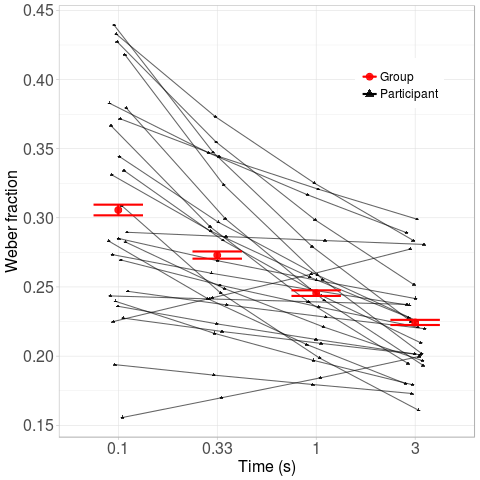

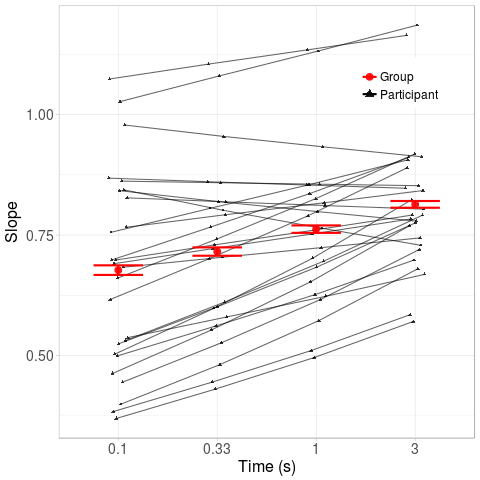

In [40]:
%%R -i sum_vals summary

sum_vals <- sum_vals %>%
            mutate(t=log(Time)) %>%
           # mutate(t=Time) %>%
            mutate(real_weber=exp(weber + 4*time_weber*t - 0.01)) %>%
            mutate(real_slope=exp(slope+1.25*time_slope * t - 0.04)) %>%
            mutate(real_weber_high=exp(weber - time_weber_high * t)) %>%
            mutate(real_weber_low=exp(weber - time_weber_low * t)) %>%
            mutate(real_slope_high=exp(slope+time_slope_high*t)) %>%
            mutate(real_slope_low=exp(slope+time_slope_low*t)) %>%

            #mutate(real_weber_=exp(weber + time_weber*Time))# %>%
            mutate(guess=real_slope*Dots_Shown) %>%
            mutate(noise=real_weber*Dots_Shown)


sum_vals$id <- seq.int(1,nrow(sum_vals))
mean_reg_vals <- sum_vals %>%
                group_by(pid, Time) %>%
               top_n(n=1, wt=id)




p.1 <- ggplot(data=sum_vals, aes(x=as.character(Time), y=real_weber)) +
       stat_summary(fun.y="mean", geom="line", size=0.5, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant"), alpha=0.6) +
       stat_summary(fun.y="mean", geom="point", size=1,alpha=0.8, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant")) +

       stat_summary(fun.data="mean_se", geom="errorbar", size=0.25, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant")) +

        stat_summary(geom="errorbar", width=0.5,size=1.0, fun.data="mean_se", aes(color="Group")) +
      stat_summary(geom="point", fun.y="mean", size=3., alpha=0.9, aes(color="Group", shape="Group")) +
    #stat_summary(fun.y="mean", geom="line", size=4) +
        scale_color_manual(name="a", values=c("Red", "Black"),labels=c("Group", "Participant")) +
        scale_shape_manual(name="a", values=c(19, 17), labels=c("Group", "Participant")) +
        #geom_errorbar(aes(ymin=real_weber - real_weber_sd, ymax=real_weber+real_weber_sd)) +
      paper_theme_2 + theme(legend.text=element_text(size=12), 
                            legend.position=c(0.82,0.82),
                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=16),
                         axis.title.x=element_text(face="plain", size=16),
                            axis.title.y=element_text(face="plain", size=16)) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +

            ylab("Weber fraction") + xlab("Time (s)")         
                        
    

p.2 <- ggplot(data=sum_vals, aes(x=as.character(Time), y=real_slope)) +
       stat_summary(fun.y="mean", geom="line", size=0.5, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant"), alpha=0.6) +
       stat_summary(fun.y="mean", geom="point",alpha=0.8, size=1.0, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant")) +


        stat_summary(geom="errorbar", width=0.5,size=1.0, fun.data="mean_se", aes(color="Group")) +
      stat_summary(geom="point", fun.y="mean", size=3., alpha=0.9, aes(color="Group", shape="Group")) +
    #stat_summary(fun.y="mean", geom="line", size=4) +
        scale_color_manual(name="a", values=c("Red", "Black"),labels=c("Group", "Participant")) +
        scale_shape_manual(name="a", values=c(19, 17), labels=c("Group", "Participant")) +
        #geom_errorbar(aes(ymin=real_weber - real_weber_sd, ymax=real_weber+real_weber_sd)) +
      paper_theme_2 + theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=14),
                            axis.text.y=element_text(size=14),
                            legend.position=c(0.82,0.82),
                         axis.title.x=element_text(face="plain", size=16),
                            axis.title.y=element_text(face="plain", size=16)) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +

            ylab("Slope") + xlab("Time (s)")  
                        
#ggsave("figs/time_weber.png", width=5,height=4,dpi=300)


p.3 <- ggplot(data=mean_reg_vals, aes(x=as.character(Time), y=(guess - Dots_Shown)/Dots_Shown)) +
           # geom_point() +
            stat_summary(fun.data="mean_se") +
            #geom_errorbar(aes(ymin=real_slope_high, ymax=real_slope_low)) +
            #facet_wrap(~pid) +
      paper_theme_2 + theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=16),
                         axis.title.x=element_text(face="plain"),
                            axis.title.y=element_text(face="plain")) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +

            ylab("Slope") + xlab("Time (s)") 

p.4 <- ggplot(data=sum_vals, aes(x=Dots_Shown, 
                                 y=(Dots_Counted-Dots_Shown)/Dots_Shown, 
                                 color=factor(Time), group=Time)) +
        stat_smooth(method="loess", span=1.5, se=FALSE) +
        stat_smooth(method="loess", span=1.5, se=TRUE, alpha=0.1)


p.4 <- ggplot(data=sum_vals, aes(x=Dots_Shown, 
                                 y=Dots_Counted/Dots_Shown, 
                                 color=factor(Time), group=Time)) +
        stat_smooth(method="loess", span=1.5, se=FALSE) +
        stat_smooth(method="loess", span=1.5, se=TRUE, alpha=0.1)

print(p.1)
ggsave("figs/time_weber.png", width=5,height=5, dpi=300)
print(p.2)
ggsave("figs/time_slope.png", width=5,height=5, dpi=300)
#print(p.4)
#print(mean_reg_vals)
print(mean(mean_reg_vals$real_weber))
print(mean(mean_reg_vals$real_weber_high))
print(mean(mean_reg_vals$real_weber_low))

#print(summary(mean_reg_vals$real_slope))

#print(mean(mean_reg_vals$time_slope))
#print(median(mean_reg_vals$time_weber))
#print(median(mean_reg_vals$time_slope))


#print(summary(lm(data=mean_reg_vals, real_slope ~ factor(Time)-1)))
#print(summary(lm(data=mean_reg_vals, real_weber ~ factor(Time)-1)))

#print(summary(lm(data=mean_reg_vals, (time_slope*Time) ~ factor(Time)-1)))

#print(p.3)
